In [1]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras import metrics
# import keras.backend as K
# from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, image_dataset_from_directory
import cv2
import glob
# from tensorflow.python.client import device_lib
# from sklearn.multiclass import OneVsRestClassifier
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass
from DataGenerator import DataGenerator

keras.backend.clear_session()



### Load Train Set
<i>-deconstruct the set-<i>

In [59]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              #<---
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )
                                        


Found 3071 files belonging to 4 classes.


In [60]:
# seperation of training target and label
# !!! these sets are not shuffled !!!

X1_train_ds = []
y1_train_ds = []
X2_train_ds = []
y2_train_ds = []


for img, label in train_ds.unbatch():
    if label.numpy() == 0:
        X1_train_ds.append(img.numpy()[:,:,0])
        y1_train_ds.append([0])

    if label.numpy() == 1:
        X2_train_ds.append(img.numpy()[:,:,0])
        y2_train_ds.append([1])



In [61]:
# create dataset for class 1 -NO oversampling- (healthy)
X1_train_ds = np.array(X1_train_ds)
X1_train_mask = X1_train_ds.astype("uint8")
y1_train_ds = np.array(y1_train_ds)

X2_train_ds = np.array(X2_train_ds)
X2_train_mask = X2_train_ds.astype("uint8")
y2_train_ds = np.array(y2_train_ds)


In [62]:
for t in range(0,len(X1_train_mask)):
    
    X1_train_mask[t] = (((X1_train_mask[t] - np.mean(X1_train_mask[t])) / np.std(X1_train_mask[t])))
    X1_train_mask[t] = np.clip(X1_train_mask[t], -1,1)
    X1_train_mask[t] = (X1_train_mask[t] + 1) / 2

for t in range(0,len(X2_train_mask)):
    
    X2_train_mask[t] = (((X2_train_mask[t] - np.mean(X2_train_mask[t])) / np.std(X2_train_mask[t])))
    X2_train_mask[t] = np.clip(X2_train_mask[t], -1,1)
    X2_train_mask[t] = (X2_train_mask[t] + 1) / 2
    

In [31]:
np.array_equal(X1_train_ds[1][:,:,0],X1_train_ds[1][:,:,1])

True

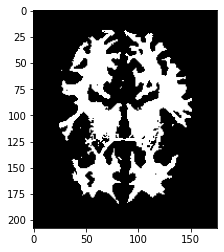

In [68]:
#plt.imshow(X1_train_ds[0].astype('uint8'))
plt.imshow(X2_train_mask[1],cmap="gray")

In [13]:
print("min",np.min(X1_train_ds[0]))
print("max",np.max(X1_train_ds[0]))
print("std",np.std(X1_train_ds[0]))




min 0.048563153
max 1.0
std 0.41911516


In [69]:
# combine all data sets with mask
X_train_fullset = np.concatenate((X1_train_ds,X2_train_ds), axis=0)
y_train_fullset = np.concatenate((X1_train_mask,X2_train_mask), axis=0)

In [70]:
# shuffle the whole set
X_train_temp, y_train_temp = shuffle(X_train_fullset, y_train_fullset, random_state=10)

In [74]:
# finally create tensor dataset
data_generator = DataGenerator(X_train_temp, y_train_temp, batch_size = 32)

train_fullTensor = tf.data.Dataset.from_generator(
                                            data_generator,
                                            output_signature=(tf.TensorSpec(shape=(None, 208, 176), dtype=tf.float32), tf.TensorSpec(shape=(None, 208, 176), dtype=tf.float32))
                                            )

### Load Validation Sets

In [78]:
# load validation dataset from drive
# set for training
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )


Found 2050 files belonging to 4 classes.


In [79]:
# seperation of validation target and label
# !!! these sets are not shuffled !!!

X1_val = []
y1_val = []
X2_val = []
y2_val = []

for img, label in val_ds.unbatch():
    if label.numpy() == 0:
        X1_val.append(img.numpy()[:,:,0])
        y1_val.append([0])

    if label.numpy() == 1:
        X2_val.append(img.numpy()[:,:,0])
        y2_val.append([1])



In [80]:
# create dataset for class 1 -NO oversampling- (healthy)
X1_val = np.array(X1_val)
X1_val_mask = X1_val.astype("uint8")
y1_val = np.array(y1_val)

X2_val = np.array(X2_val)
X2_val_mask = X2_val.astype("uint8")
y2_val = np.array(y2_val)

In [81]:
for t in range(0,len(X1_val_mask)):
    
    X1_val_mask[t] = (((X1_val_mask[t] - np.mean(X1_val_mask[t])) / np.std(X1_val_mask[t])))
    X1_val_mask[t] = np.clip(X1_val_mask[t], -1,1)
    X1_val_mask[t] = (X1_val_mask[t] + 1) / 2

for t in range(0,len(X2_val_mask)):
    
    X2_val_mask[t] = (((X2_val_mask[t] - np.mean(X2_val_mask[t])) / np.std(X2_val_mask[t])))
    X2_val_mask[t] = np.clip(X2_val_mask[t], -1,1)
    X2_val_mask[t] = (X2_val_mask[t] + 1) / 2

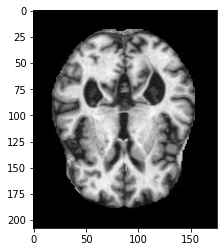

In [106]:
plt.imshow(X_val_eval[0].astype("uint8"),cmap="gray")

In [87]:
# combine all data sets
X_val_fullset = np.concatenate((X1_val,X2_val), axis=0)
y_val_fullset = np.concatenate((X1_val_mask,X2_val_mask), axis=0)

In [88]:
# shuffle the whole set
X_val_temp, y_val_temp = shuffle(X_val_fullset, y_val_fullset, random_state=10)

In [90]:
# finally create tensor dataset
data_generator = DataGenerator(X_val_temp, y_val_temp, batch_size = 32)

val_fullTensor = tf.data.Dataset.from_generator(
                                            data_generator,
                                            output_signature=(tf.TensorSpec(shape=(None, 208, 176, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, 208, 176, 1), dtype=tf.float32))
                                            )

# keep seperate val set for later validation
X_val_eval = X_val_temp
y_val_eval = y_val_temp

In [95]:
val_fullTensor

<FlatMapDataset element_spec=(TensorSpec(shape=(None, 208, 176), dtype=tf.float32, name=None), TensorSpec(shape=(None, 208, 176), dtype=tf.float32, name=None))>

### Build CNN Architecture and Model Fitting

In [94]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [100]:
IMG_HEIGHT = 208
IMG_WIDTH = 176
CHANNELS = 1

inputs = Input((IMG_HEIGHT, IMG_WIDTH, CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 208, 176, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 208, 176, 1)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 208, 176, 16  160         ['lambda_3[0][0]']               
                                )                                                                 
                                                                                            

In [98]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=train_ds.cardinality().numpy()*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')


In [101]:
#compiling the model architecture and start fit
keras.backend.clear_session()
#model.compile(optimizer=optimizer,
#              loss="BinaryCrossentropy",
#              metrics=[metrics.Precision(), metrics.Recall()])


with tf.device("/gpu:0"):
    history = model.fit(x=train_fullTensor,
                        validation_data=val_fullTensor,
                        epochs=10, 
                        shuffle=True,               #not sure if used with batched tf dataset
                        )
                        
                    

Epoch 1/10
82/82 [==============================] - 14s 94ms/step - loss: 0.1604 - precision: 0.8328 - recall: 0.8674 - val_loss: 0.0801 - val_precision: 0.9255 - val_recall: 0.9316
Epoch 2/10
82/82 [==============================] - 6s 76ms/step - loss: 0.0684 - precision: 0.9352 - recall: 0.9402 - val_loss: 0.0632 - val_precision: 0.9013 - val_recall: 0.9880
Epoch 3/10
82/82 [==============================] - 6s 76ms/step - loss: 0.0563 - precision: 0.9475 - recall: 0.9494 - val_loss: 0.0673 - val_precision: 0.8918 - val_recall: 0.9929
Epoch 4/10
82/82 [==============================] - 6s 76ms/step - loss: 0.0480 - precision: 0.9557 - recall: 0.9563 - val_loss: 0.0482 - val_precision: 0.9285 - val_recall: 0.9871
Epoch 5/10
82/82 [==============================] - 6s 76ms/step - loss: 0.0437 - precision: 0.9603 - recall: 0.9594 - val_loss: 0.0428 - val_precision: 0.9386 - val_recall: 0.9859
Epoch 6/10
82/82 [==============================] - 6s 76ms/step - loss: 0.0418 - precision: 0

### Model Evaluation

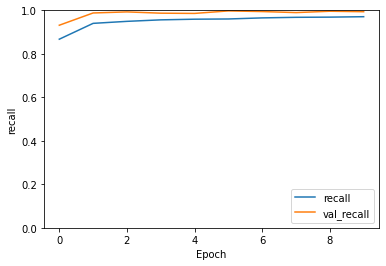

In [102]:
#print val vs accuracy

keras.backend.clear_session()
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [103]:
test_preds = model.predict(X_val_eval)

55/55 [==============================] - 2s 26ms/step


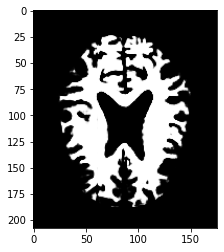

In [127]:
plt.imshow(test_preds[1], cmap='gray')

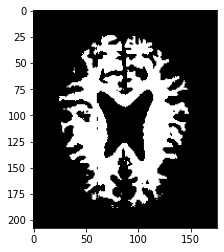

In [125]:
plt.imshow(y_val_eval[1], cmap='gray')

In [ ]:
y_pred = model.predict(X_val_eval, batch_size=1, verbose=1)

for idx, label in enumerate(y_pred):
    if label > 0.5:
        y_pred[idx] = 1
    if label <= 0.5:
        y_pred[idx] = 0

test_loss, test_prec, test_rec, test_auc  = model.evaluate(val_fullTensor, verbose=2)

1742/1742 [==============================] - 2s 1ms/step
55/55 - 1s - loss: 0.1745 - precision: 0.9129 - recall: 0.9651 - auc: 0.9852 - 1s/epoch - 21ms/step


In [ ]:
recall_score(y_val_eval,y_pred)

0.9651324965132496

In [ ]:
confusion_matrix(y_val_eval,y_pred)

array([[959,  66],
       [ 25, 692]], dtype=int64)

### Load seperate test set (OASIS cross sections)

In [ ]:
metaData = pd.read_csv("F:\MRI_class\data\oasis_cross_sectional.csv")
metaData = metaData[metaData.Age >= 50]
metaData = metaData[["ID","CDR"]]

# imputing missing 0
metaData.CDR[metaData.CDR.isna() == True] = 0
metaData = metaData.drop(metaData.CDR[metaData.CDR > 1].index)

#get file names
path = "F:\MRI_class\data\horizontal_masked"
#path = "/Users/stephanbremser/neuefische/alzheimer-classification/data/horizontal_masked"#"~/neuefische/alzheimer-classification/data/horizontal_masked"
path_list = os.listdir(path)

#create file list matching the path_list
t = pd.DataFrame(path_list)

#merge metadata dataframe with file list on ID
f = lambda x: x[0:13] #merge on first 13 letters (eg "OAS1_0001_MR1")
t["ID"]=t[0].apply(f)

metaData = pd.merge(metaData, t,on="ID", how="left")
metaData = metaData.rename(columns={0:"file"})

metaData.CDR[metaData["CDR"] == 0.5] =  1



C:\Users\wolle\AppData\Local\Temp\ipykernel_17340\3706787863.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metaData.CDR[metaData["CDR"] == 0.5] =  1


In [ ]:
images_class0 = []
images_class1 = []
label_class0 = []
label_class1 = []


for t, i in enumerate(metaData.file):
    temp_path = path+"\\"+i
    if metaData.CDR[t] == 0:
    
        image1 = tf.keras.preprocessing.image.load_img(temp_path)
        image1 = tf.keras.preprocessing.image.img_to_array(image1)
        images_class0.append(image1)
        label_class0.append(metaData.CDR[t])
        
    if metaData.CDR[t] == 1:
        
        
        image1 = tf.keras.preprocessing.image.load_img(temp_path)
        image1 = tf.keras.preprocessing.image.img_to_array(image1)
        images_class1.append(image1)
        label_class1.append(metaData.CDR[t])

images_class0 = np.array(images_class0)    
images_class1 = np.array(images_class1)
label_class0 = np.array(label_class0)
label_class1 = np.array(label_class1)



In [ ]:
oasis_test_images = np.concatenate((images_class0,images_class1))
oasis_test_labels = np.concatenate((label_class0,label_class1))
X_test_oasis, y_test_oasis = shuffle(oasis_test_images, oasis_test_labels, random_state=10)

In [ ]:
oasis_pred = model.predict(X_test_oasis, batch_size=1, verbose=1)

229/229 [==============================] - 0s 2ms/step


In [ ]:
for idx, label in enumerate(oasis_pred):
    if label > 0.5:
        oasis_pred[idx] = 1
    if label <= 0.5:
        oasis_pred[idx] = 0

In [ ]:
print("recall score:", recall_score(y_test_oasis,oasis_pred))
print("precision score:", precision_score(y_test_oasis,oasis_pred))

recall score: 0.9693877551020408
precision score: 0.4460093896713615


In [ ]:
confusion_matrix(y_test_oasis,oasis_pred)

array([[ 13, 118],
       [  3,  95]], dtype=int64)

In [ ]:
#!mkdir -p saved_model2
model.save("F:\\MRI_class\\data\\model_binary")

Ein Unterverzeichnis oder eine Datei mit dem Namen "-p" existiert bereits.
Folgender Fehler trat auf: -p.


INFO:tensorflow:Assets written to: F:\MRI_class\data\model_binary\assets


INFO:tensorflow:Assets written to: F:\MRI_class\data\model_binary\assets
